# This notebook is to explore the nature of the critical genes identified by ASSIST workflow

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
import os
from itertools import combinations
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
from src.eda.eda_functions import jaccard_similarity
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# load critical gene lists and embedding names
critical_gene_dfs = []
embedding_names = []
critical_gene_path = prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/'
for file in os.listdir(critical_gene_path):
    critical_gene_dfs.append(pd.read_csv(critical_gene_path + file))
    emb_name = '_'.join(file.split('_')[:3])
    embedding_names.append(emb_name)

In [6]:
comm_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/network_louvain_default.csv')

In [8]:
critical_gene_dfs_w_module = []
for df in critical_gene_dfs:
    merged_df = pd.merge(df, comm_df, left_on = 'gene', right_on = 'id')
    critical_gene_dfs_w_module.append(merged_df)

# Determine the original module id for the critical genes for each embedding

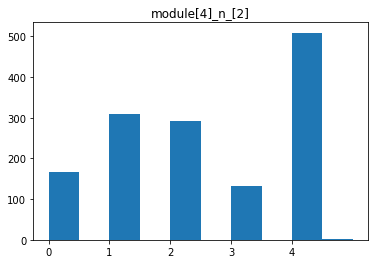

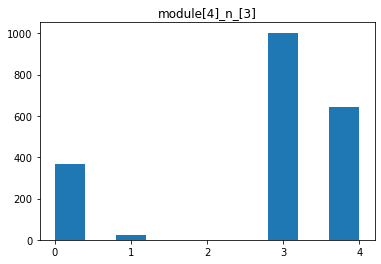

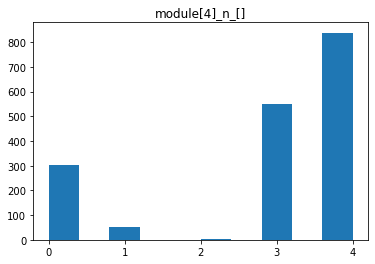

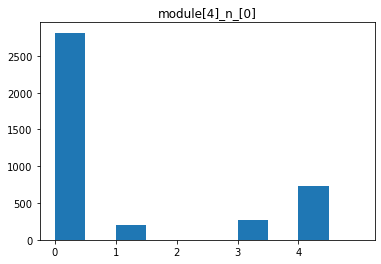

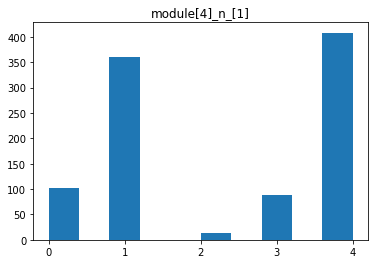

In [29]:
for i in range(len(critical_gene_dfs)):
    plt.hist(critical_gene_dfs_w_module[i]['louvain_label'])
    plt.title(embedding_names[i])
    plt.xticks([x for x in range(5)])
    plt.show()
    plt.close();

# Critical gene importance: how to rank them
## 1. Common ones between the models?
## 2. Common ones between the embeddings regardless of the rank
## 3. Centrality of the nodes in the original network?

In [35]:
critical_gene_sets = [set(critical_gene_dfs_w_module[i]['gene']) for i in range(5)]
common_critical_genes_all_emb = list(set.intersection(*critical_gene_sets))

In [39]:
# critical genes shared by all embeddings and their original module id (ranking is ignored here)
comm_df[comm_df.id.isin(common_critical_genes_all_emb)]

,id,louvain_label
266,ENSG00000173369,4
338,ENSG00000117758,0
1354,ENSG00000158710,4
1395,ENSG00000203747,4
1646,ENSG00000133048,4
2312,ENSG00000122862,4
2852,ENSG00000167244,4
9047,ENSG00000099860,4
9830,ENSG00000125753,4
14816,ENSG00000145623,4


# Plot # of common critical genes between each pair of embeddings: embeddings with high ML scores tend to share more critical genes in common

In [191]:
common_gene_cnt = []
embedding_comparisons = []
for a, b in combinations([0,1,2,3,4], 2):
    critical_gene_sets = [set(critical_gene_dfs_w_module[i]['gene']) for i in [a,b]] 
    common_gene_cnt.append(len(set.intersection(*critical_gene_sets)))
    embedding_comparisons.append(f'{embedding_names[a]} vs {embedding_names[b]}')

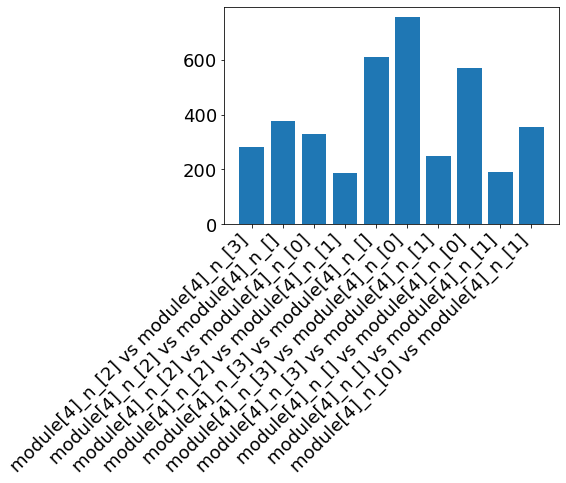

In [192]:
plt.bar(embedding_comparisons, common_gene_cnt)
plt.xticks(rotation = 45, ha='right');

## Same as above, except only the top 50 critical genes are considered

In [193]:
common_gene_cnt = []
embedding_comparisons = []
for a, b in combinations([0,1,2,3,4], 2):
    critical_gene_sets = [set(critical_gene_dfs_w_module[i]['gene'][:50]) for i in [a,b]] 
    common_gene_cnt.append(len(set.intersection(*critical_gene_sets)))
    embedding_comparisons.append(f'{embedding_names[a]} vs {embedding_names[b]}')

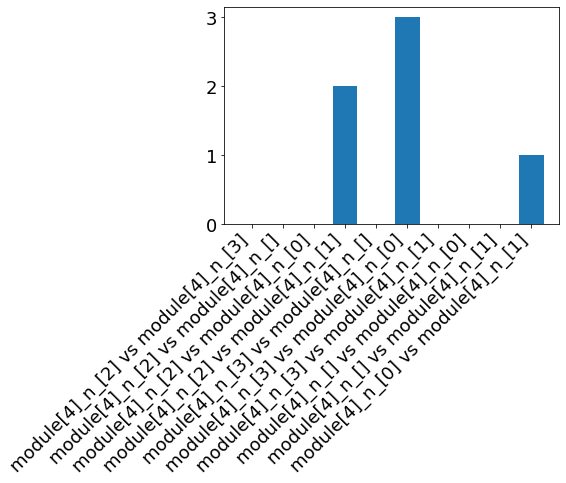

In [194]:
plt.bar(embedding_comparisons, common_gene_cnt)
plt.xticks(rotation = 45, ha='right');

# Check if the critical genes extracted from Deep Response Model are just the genes that share large weights with DEGs
## A sanity check to see that the DRM found other features to help identify critical genes

In [42]:
# subnetwork = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/subnetworks_Jan_14/deg_mod=[4],non_deg_mod=[0],num_genes=100,min_weight=0.015.csv', index_col = 0)

In [104]:
deseq = pd.read_excel(prefix + '/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [101]:
def join_subnetwork_w_deseq(subnetwork, deseq):
    if 'abs_log2FC' not in deseq.columns:
        deseq['abs_log2FC'] = abs(deseq['log2FoldChange'])
    subnetwork_w_DE = pd.merge(subnetwork, deseq[['id','abs_log2FC']], left_index = True, right_on = 'id')
    subnetwork_w_DE.index = subnetwork_w_DE['id']
    return subnetwork_w_DE

In [49]:
subnetwork_w_DE = pd.merge(subnetwork, deseq[['id','abs_log2FC']], left_index = True, right_on = 'id')
subnetwork_w_DE.index = subnetwork_w_DE['id']

In [124]:
def get_network_important_genes(subnetwork_w_de, cutoff = 0.03):
    network_important_gene_dict = {}
    for col in subnetwork_w_de.columns[:-2]:
        subset = subnetwork_w_de[(subnetwork_w_de[col].between(cutoff, 0.99)) & (subnetwork_w_de['abs_log2FC'] > 0.2)][col]
        if len(subset) > 0:
            network_important_gene_dict[col] = len(subset)
    return network_important_gene_dict

In [139]:
def plot_critical_n_important_gene_jaccard(critical_gene_dfs, network_important_gene_dicts, embedding_names):
    '''Jaccard to determine overlap between critical genes found by DRM and in the original network'''
    jac_list = []
    for i in range(len(critical_gene_dfs)):
        jac = jaccard_similarity(critical_gene_dfs[i].gene.tolist(), network_important_gene_dicts[i].keys())
        jac_list.append(jac)
    plt.figure
    plt.bar(embedding_names, jac_list)
    plt.xticks(rotation = 45, ha = 'right')
    plt.ylabel('jaccard similarity')
    plt.rcParams.update({'font.size':18})
    plt.title('Critical genes vs important genes')

In [105]:
embedding_names

['module[4]_n_[2]',
 'module[4]_n_[3]',
 'module[4]_n_[]',
 'module[4]_n_[0]',
 'module[4]_n_[1]']

In [112]:
subnetwork_path = prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/subnetworks_Jan_14/'
subnetwork_dfs = []
for file in ['deg_mod=[4],non_deg_mod=[2],num_genes=150,min_weight=0.01.csv', 'deg_mod=[4],non_deg_mod=[3],num_genes=150,min_weight=0.02.csv',
             'deg_mod=[4],non_deg_mod=[],num_genes=250,min_weight=0.008.csv','deg_mod=[4],non_deg_mod=[0],num_genes=100,min_weight=0.015.csv', 'deg_mod=[4],non_deg_mod=[1],num_genes=125,min_weight=0.01.csv']:
    subnetwork = pd.read_csv(subnetwork_path + file, index_col = 0)
    subnetwork_dfs.append(subnetwork)

In [113]:
subnetwork_w_deseq_dfs = []
for subnetwork in subnetwork_dfs:
    subnetwork_w_deseq_dfs.append(join_subnetwork_w_deseq(subnetwork, deseq))

In [135]:
network_important_gene_list = []
for subnetwork_w_deseq in subnetwork_w_deseq_dfs:
    network_important_gene_list.append(get_network_important_genes(subnetwork_w_deseq, cutoff = 0.01))

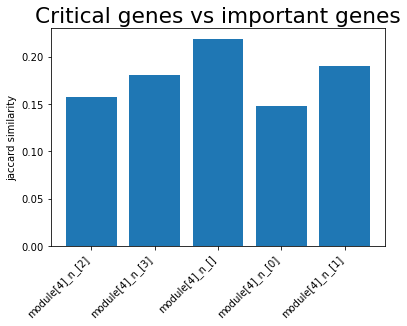

In [140]:
plot_critical_n_important_gene_jaccard(critical_gene_dfs_w_module, network_important_gene_list, embedding_names)